# L3: Cohort analysis and other error analysis methods

## Setup

In [2]:
import numpy as np

np.random.seed(41)


import shap

X, y = shap.datasets.adult()

In [3]:
X.sample(5)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
31346,64.0,1,10.0,2,14,4,4,1,0.0,0.0,40.0,39
26864,17.0,4,7.0,4,8,3,4,0,0.0,0.0,5.0,39
30544,24.0,4,10.0,4,6,3,4,1,0.0,0.0,30.0,39
17397,45.0,4,10.0,2,3,4,4,1,0.0,1848.0,40.0,39
10168,28.0,4,13.0,4,10,0,4,0,0.0,0.0,40.0,39


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [5]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [6]:
knn.score(X_valid, y_valid)

0.8464609243052357

## Groupings into cohorts

#### Based on sex

In [6]:
X_valid_reindex = X_valid.reset_index().drop("index", axis=1)

In [7]:
X_valid_males = X_valid_reindex[X_valid_reindex["Sex"] == 1]
X_valid_females = X_valid_reindex[X_valid_reindex["Sex"] == 0]

In [9]:
knn.score(X_valid_males, y_valid[X_valid_males.index])

0.8111904213677181

In [10]:
knn.score(X_valid_females, y_valid[X_valid_females.index])

0.9170506912442397

#### Based on number of years of education

In [11]:
X_valid_reindex = X_valid.reset_index().drop("index", axis=1)

In [15]:
X_valid_uni = X_valid_reindex[X_valid_reindex["Education-Num"] > 12]
X_valid_hs = X_valid_reindex[X_valid_reindex["Education-Num"] <= 12]

In [16]:
knn.score(X_valid_uni, y_valid[X_valid_uni.index])

0.77897403419886

In [17]:
knn.score(X_valid_hs, y_valid[X_valid_hs.index])

0.8680583704904743

#### Based on age brackets

In [11]:
X_valid_reindex = X_valid.reset_index().drop("index", axis=1)

In [28]:
X_valid_to_35 = X_valid_reindex[(X_valid_reindex["Age"] <= 35) & (X_valid_reindex["Age"] > 18)]
X_valid_to_55 = X_valid_reindex[X_valid_reindex["Age"] <= 55]
X_valid_over_55 = X_valid_reindex[X_valid_reindex["Age"] > 55]

In [30]:
knn.score(X_valid_to_35, y_valid[X_valid_to_35.index])

0.9147121535181236

In [31]:
knn.score(X_valid_to_55, y_valid[X_valid_to_55.index])

0.8526371123182057

In [29]:
knn.score(X_valid_over_55, y_valid[X_valid_over_55.index])

0.8027295285359801

You got the idea...

## Manifold-like groupings

Manifold is a model analysis and debugging tool proposed by Uber. At its core, it tries to group model predictions and analyze them. Manifold can be useful when deciding which model to use for which segment of inputs.

Manifold does the following steps:
1. Predict classes probability or do a regression
2. Compute the loss, for classification it's log_loss, for regression it's MSE, but anything continuous will do
3. Cluster the input data based on either:
  - the loss of a single or both models,
  - or based on some input features,
  - or based on both losses and features.
4. Visualize the distributions of features in different clusters

Once you're done, you can now ask questions like: why is this model performing worse than that model? or which model performs best on which group of inputs?

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.cluster import KMeans

from sklearn.metrics import log_loss

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

from argparse import Namespace

In [ ]:
args = Namespace(**{"n_clusters": 2, "cluster_on": "all_models_losses"})


X_test, y_test = X_valid, y_valid

In [ ]:
model1 = LogisticRegression()
model2 = GaussianNB()
model3 = LogisticRegression(penalty="l1", solver="saga")

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

In [10]:
def make_analysis(models, X_test, y_test, loss=log_loss, labels=[0, 1], args=args):
    losses = []
    for model in models:
        y_hat = model.predict_proba(X_test)
        losses.append(np.array([loss([t], [p], labels=labels)
                                   for t, p in zip(y_test, y_hat)]).reshape(-1, 1))

    losses = np.hstack(losses)

    cluster = KMeans(n_clusters=args.n_clusters)
    if args.cluster_on == "first_model_loss":
        segments = cluster.fit_predict(losses[:, 0].reshape(-1, 1))
    elif args.cluster_on == "all_models_losses":
        segments = cluster.fit_predict(losses)
    elif args.cluster_on == "with_features":
        segments = cluster.fit_predict(np.hstack([X_test, losses]))
    elif args.cluster_on == "just_features":
        segments = cluster.fit_predict(np.hstack([X_test, losses]))


    data = pd.DataFrame({
        "data_index": np.hstack([i for i, _ in enumerate(y_test)] * len(models)),
        "losses": np.hstack([losses[:, i] for i in range(len(models))]),
        "segments": np.hstack([segments.astype(str)] * len(models)),
        "models": [n for ns in [[f"{model}"] * len(losses) for model in models]
                        for n in ns]
       })

    return data

Now let's plot

In [127]:
data = make_analysis([knn, model1, model2, model3], X_test, y_test, loss=log_loss, labels=[0, 1], args=args)

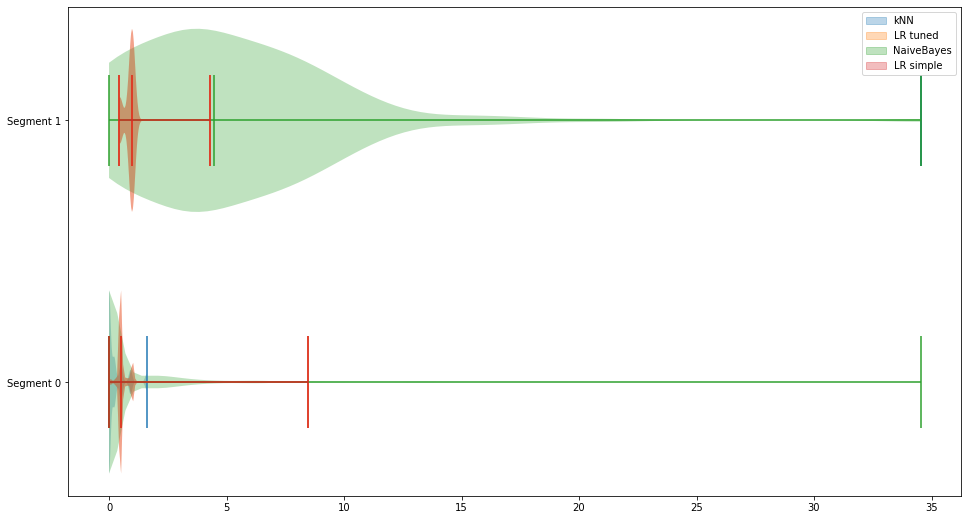

In [139]:
import matplotlib.patches as mpatches

# based on https://stackoverflow.com/a/58324984/5428334
labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))


knn_plots = [
    data[(data.models == "KNeighborsClassifier()") & (data.segments == "0")]["losses"],
    data[(data.models == "KNeighborsClassifier()") & (data.segments == "1")]["losses"]
]
lr_plots = [
    data[(data.models == "LogisticRegression(penalty='l1', solver='saga')") & (data.segments == "0")]["losses"],
    data[(data.models == "LogisticRegression(penalty='l1', solver='saga')") & (data.segments == "1")]["losses"]
]
nb_plots = [
    data[(data.models == "GaussianNB()") & (data.segments == "0")]["losses"],
    data[(data.models == "GaussianNB()") & (data.segments == "1")]["losses"]
]
lr2_plots = [
    data[(data.models == "LogisticRegression(penalty='l1', solver='saga')") & (data.segments == "0")]["losses"],
    data[(data.models == "LogisticRegression(penalty='l1', solver='saga')") & (data.segments == "1")]["losses"]
]


fig, ax = plt.subplots(figsize=(16, 9))

yticklabels = ['Segment 0', 'Segment 1']
ax.set_yticks([1, 2])
ax.set_yticklabels(yticklabels)

add_label(ax.violinplot(knn_plots, showmedians=True, vert=False, widths=0.7), "kNN")
add_label(ax.violinplot(lr_plots, showmedians=True, vert=False, widths=0.7), "LR tuned")
add_label(ax.violinplot(nb_plots, showmedians=True, vert=False, widths=0.7), "NaiveBayes")
add_label(ax.violinplot(lr2_plots, showmedians=True, vert=False, widths=0.7), "LR simple")


plt.legend(*zip(*labels), loc=0)

Or a bit simpler but less flexible

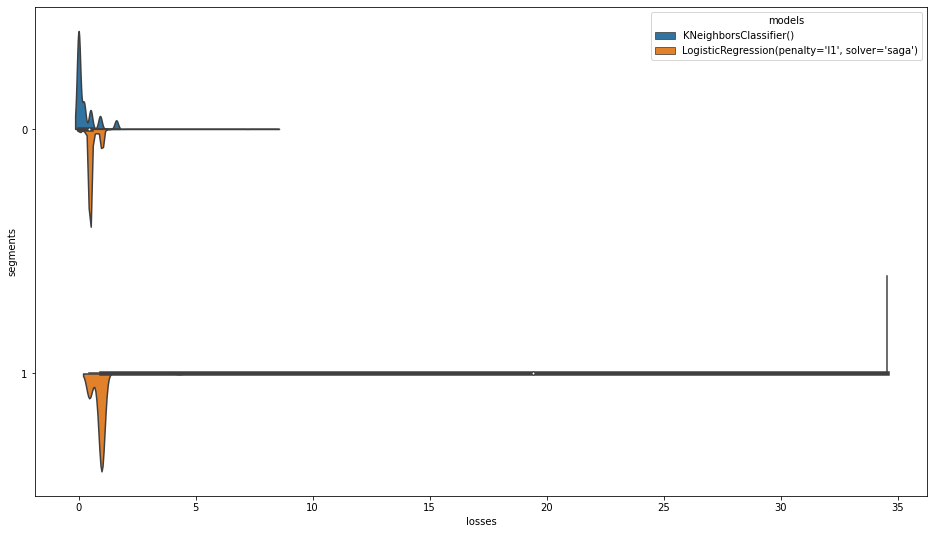

In [125]:
data = make_analysis([knn, model3], X_test, y_test, loss=log_loss, labels=[0, 1], args=args)

# Using seaborn's violin plot only works with 2 models
fig, ax = plt.subplots(figsize=(16, 9))
sns.violinplot(x="losses", y="segments", hue="models", data=data, split=True, scale="width", ax=ax, orient="h")
plt.show()

In [55]:
def make_feature_segments(X: np.ndarray, data):
    data.index = [i for i in range(len(X))] * (len(data.values) // len(X))
    return {seg: X[np.unique(data[data.segments == seg].index)] for seg in np.unique(data.segments)}

In [58]:
# print(make_feature_segments(X_test.values, data))
# it will basically be a dict where the key is the segment and the value a numpy array

In [134]:
def compare_segments(group_1, group_2, segments_dict):
    group_1_features, group_2_features = [], []

    for segment, features in segments_dict.items():
        if segment in group_1:
            group_1_features.append(features)
        elif segment in group_2:
            group_2_features.append(features)

    if len(group_1_features) > 1:
        group_1_features = np.vstack(group_1_features)
    else:
        group_1_features = group_1_features[0]

    if len(group_2_features) > 1:
        group_2_features = np.vstack(group_2_features)
    else:
        group_2_features = group_2_features[0]

    dfl = list()
    
    if group_1_features.shape[0] > group_2_features.shape[0]:
        temp = np.zeros_like(group_1_features)
        temp[0:group_2_features.shape[0], :] = group_2_features
        group_2_features = temp
    else:
        temp = np.zeros_like(group_2_features)
        temp[0:group_1_features.shape[0], :] = group_1_features
        group_1_features = temp


    for feature_idx in range(group_2_features.shape[-1]):
        df = pd.DataFrame({
            "row": feature_idx,
            "group_1_value": group_1_features[:, feature_idx],
            "group_2_value": group_2_features[:, feature_idx]})
        dfl.append(df)

    df = pd.concat(dfl)

    g = sns.FacetGrid(df, row="row", sharex=False, sharey=False)
    g.map(sns.kdeplot, "group_1_value", color="r")
    g.map(sns.kdeplot, "group_2_value", color="k")

    return g

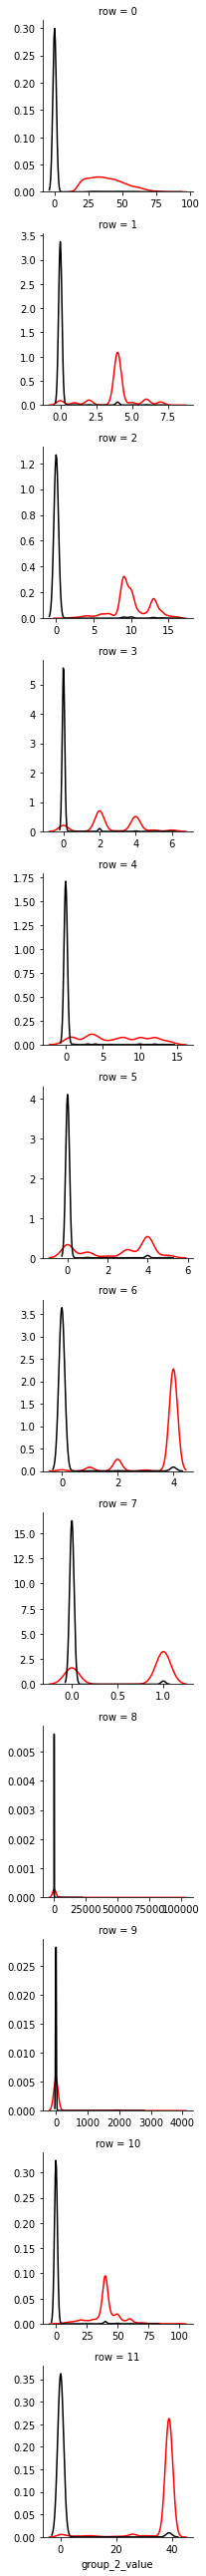

In [140]:
g = compare_segments(["0"], ["1"], make_feature_segments(X_test.values, data))
plt.show()

Well, it doesn't look as good as [the original](https://www.youtube.com/watch?v=paJNSODuu3c), but can be just as helpful.

## Nearest neighbor (most similar) search in feature and target space

As per [Microsoft's Gamut](https://www.microsoft.com/en-us/research/project/msrgamut/) paper, we know that while developing machine learning models, answering questions of the form: _what is the most similar dataset entry to X_ maybe with some additional "constraints" like attribute value or range of values, or prediction result, or whatever, could prove very useful.

The method below searches for similarities at the feature level, and not model level. In other words, it searches for similarities from the point of view of data and not the model that we are trying to understand.

To allow for searching of most similar items from model's point o view, we would need an embedding from the model. It is fairly easy to do using neural networks, but for other classes of models, I honestly don't really know how to do it. Maybe if you do, drop me a message about it ;)

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd


Nearest neighbor algorithm is very sensitive about dimensions and scaling, that's why we'll use `StandardScaler` to avoid subsequent issues.

In [71]:
scaler = StandardScaler()
q_knn = NearestNeighbors()

q_knn.fit(scaler.fit_transform(np.hstack([X_valid.values, y_valid.reshape(-1, 1)])))

NearestNeighbors()

#### Most similar to X

In [63]:
X_valid.iloc[0]

Age                39.0
Workclass           4.0
Education-Num      10.0
Marital Status      0.0
Occupation          4.0
Relationship        1.0
Race                4.0
Sex                 0.0
Capital Gain        0.0
Capital Loss      625.0
Hours per week     40.0
Country            39.0
Name: 18329, dtype: float64

In [72]:
query = [np.hstack([X_valid.iloc[0].values, y_valid[0]])]

candidate_dist, candidate_idx = q_knn.kneighbors(scaler.transform(query), n_neighbors=5, return_distance=True)

In [73]:
X_valid.iloc[candidate_idx.flatten()[1:]]

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
23714,39.0,4,10.0,0,4,1,4,0,0.0,0.0,39.0,39
91,37.0,4,10.0,0,3,1,4,0,0.0,0.0,40.0,39
16774,38.0,4,9.0,0,4,1,4,0,0.0,0.0,40.0,39
23885,40.0,4,9.0,0,4,1,4,0,0.0,0.0,40.0,39


In [74]:
candidate_dist

array([[0.        , 1.55815669, 1.58065146, 1.60742423, 1.60742423]])

#### Most similar to X but a different prediction

In [75]:
X_valid.iloc[0]

Age                39.0
Workclass           4.0
Education-Num      10.0
Marital Status      0.0
Occupation          4.0
Relationship        1.0
Race                4.0
Sex                 0.0
Capital Gain        0.0
Capital Loss      625.0
Hours per week     40.0
Country            39.0
Name: 18329, dtype: float64

In [76]:
query = [np.hstack([X_valid.iloc[0].values, not y_valid[0]])]

candidate_dist, candidate_idx = q_knn.kneighbors(scaler.transform(query), n_neighbors=5, return_distance=True)

In [77]:
X_valid.iloc[candidate_idx.flatten()]

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
17186,37.0,4,10.0,0,4,0,4,0,0.0,0.0,40.0,39
29358,35.0,4,10.0,0,4,0,4,0,0.0,0.0,40.0,39
6199,32.0,4,10.0,0,4,0,4,0,0.0,0.0,50.0,39
7377,41.0,4,10.0,0,8,0,4,0,0.0,0.0,36.0,39
7199,48.0,4,9.0,0,1,0,4,0,0.0,0.0,37.0,39


In [78]:
candidate_dist

array([[1.66348994, 1.68302119, 1.92050703, 1.94026954, 1.97609215]])

#### Most similar to X but a different attribute value

In [41]:
X_valid.iloc[0]

Age                39.0
Workclass           4.0
Education-Num      10.0
Marital Status      0.0
Occupation          4.0
Relationship        1.0
Race                4.0
Sex                 0.0
Capital Gain        0.0
Capital Loss      625.0
Hours per week     40.0
Country            39.0
Name: 18329, dtype: float64

In [80]:
example = X_valid.iloc[0].copy()
example.Age = 50
example["Education-Num"] = 13

In [81]:
query = [np.hstack([example.values, y_valid[0]])]

candidate_dist, candidate_idx = q_knn.kneighbors(scaler.transform(query), n_neighbors=5, return_distance=True)

In [82]:
X_valid.iloc[candidate_idx.flatten()]

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
18329,39.0,4,10.0,0,4,1,4,0,0.0,625.0,40.0,39
16002,50.0,4,13.0,0,4,1,4,0,0.0,0.0,40.0,39
3279,45.0,4,13.0,0,4,1,4,0,0.0,0.0,40.0,39
31485,48.0,4,12.0,0,4,1,4,0,0.0,0.0,42.0,39
18260,42.0,4,12.0,0,4,1,4,0,0.0,0.0,40.0,39


In [83]:
candidate_dist

array([[1.4403224 , 1.55598581, 1.59914408, 1.62086235, 1.71083632]])